# 문화생활과 폭염 상관관계

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob

# 그래프 폰트
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

In [6]:
def preprocessing(data_df) :
    use_cols = ['측정시간', '온도 최대(℃)']
    # 컬럼명 시작 끝 공백 제거
    data_df.columns = data_df.columns.str.strip()

    data_df = data_df[use_cols]

    data_df.columns = data_df.columns.str.strip()

    data_df = data_df.dropna()

    # datetime 이상치 제거
    # 문자열로
    datetime_str = data_df['측정시간'].astype(str).str.strip()

    # _제거
    datetime_str = datetime_str.str.replace('_', ' ', regex=True)
    # 12~14자리 숫자(YYYYMMDDHHMMSS / YYYYMMDDHHMM)만 추출해서 파싱
    dt_num = pd.to_datetime(datetime_str, format='%Y-%m-%d %H:%M:%S', errors='coerce')
    dt_mix = pd.to_datetime(datetime_str, format='mixed', errors='coerce')

    # 포맷 병합
    data_df['측정시간'] = dt_num.fillna(dt_mix)

    # 일시->날짜로 컬럼 추가
    data_df['측정시간'] = pd.to_datetime(data_df['측정시간'])
    data_df['측정시간'] = data_df['측정시간'].dt.date
    
    data_df.columns = ['date', 'max_temp']

    # 최대기온
    data_df = data_df.groupby('date')['max_temp'].max().reset_index()
    
    # 이상치 제거
    data_df = data_df[(data_df['max_temp'] >= 0) & (data_df['max_temp'] <= 41)]
    
    return data_df

In [7]:
# 폭염 데이터 로드 2023
path = "./data/폭염/S-DoT_NATURE_2023*.csv"
files = glob.glob(path)
df_list = [pd.read_csv(f, encoding='euc-kr') for f in files]
heat_df1 = pd.concat(df_list, ignore_index=True)

# 폭염 데이터 로드 2024
path = "./data/폭염/120_서울시 IOT 복합 센서(환경정보)_PUBDATA_2024*.csv"

files = glob.glob(path)

df_list = [pd.read_csv(f, encoding='euc-kr') for f in files]

heat_df2 = pd.concat(df_list, ignore_index=True)

heat_df1 = preprocessing(heat_df1)
heat_df2 = preprocessing(heat_df2)

C:\Users\Playdata\AppData\Local\Temp\ipykernel_7944\798561316.py:4: DtypeWarning: Columns (18,26,54,55,56) have mixed types. Specify dtype option on import or set low_memory=False.
  df_list = [pd.read_csv(f, encoding='euc-kr') for f in files]


In [8]:
# 두 dataframe 합치기
heat_df = pd.merge(
    heat_df1,
    heat_df2,
    how='outer',
    on='date',
    suffixes=('_df1', '_df2')
)
# 분리된 컬럼 합치기
heat_df['max_temp'] = heat_df['max_temp_df1'].combine_first(heat_df['max_temp_df2'])
heat_df = heat_df.drop(columns=['max_temp_df1', 'max_temp_df2'])

# 데이터 확인
print(heat_df['date'].min())
print(heat_df['date'].max())

# 중복값 확인
heat_df['date'].duplicated().sum()
heat_df['date'] = pd.to_datetime(heat_df['date'], errors='coerce')

2023-04-03
2024-10-31


In [9]:
heat_df['max_temp'].isna().any()
heat_df['date'].isna().any()

np.False_

In [10]:
heat_df.isna().sum()

date        0
max_temp    0
dtype: int64

In [11]:
# 예술의 전당 문화생활 데이터
path = "./data/문화생활/예술의전당_*.csv"

files = glob.glob(path)

df_list = [pd.read_csv(f) for f in files]

art_center_df = pd.concat(df_list, ignore_index=True)

# 일자 컬럼 데이터 타입 변경
art_center_df['일자'] = pd.to_datetime(art_center_df['일자'], errors='coerce')
art_center_df['일자'] = art_center_df['일자'].dt.date

# 일별 방문 합계
art_center_df = art_center_df.groupby('일자')['합계'].sum().reset_index()
art_center_df.columns = ['date', 'art_center_total_visit']
art_center_df['date'] = pd.to_datetime(art_center_df['date'], errors='coerce')
art_center_df = art_center_df.dropna()
art_center_df

,date,art_center_total_visit
0,2023-01-01,6393
1,2023-01-03,4536
2,2023-01-04,6566
3,2023-01-05,4272
4,2023-01-06,5251
...,...,...
940,2025-12-26,3726
941,2025-12-27,7434
942,2025-12-28,5709
943,2025-12-30,5963


In [12]:
cultural_heat = pd.merge(heat_df, art_center_df, on='date', how='inner')

In [15]:
cultural_heat = cultural_heat[(cultural_heat['max_temp'] >= 31)]

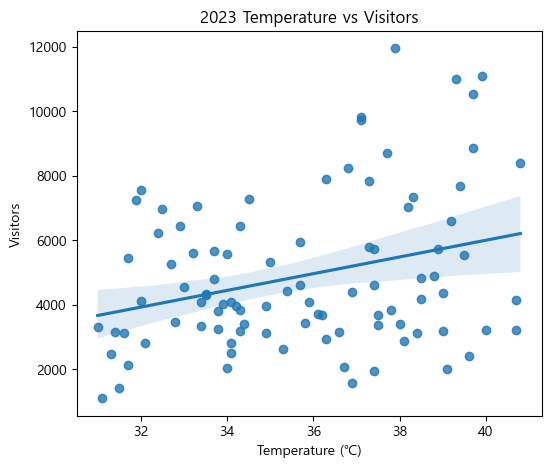

In [25]:

cultural_heat['date'] = pd.to_datetime(cultural_heat['date'])
cultural_heat['year'] = cultural_heat['date'].dt.year

df_2023 = cultural_heat[cultural_heat['year'] == 2023]

plt.figure(figsize=(6,5))
sns.regplot(
    data=df_2023,
    x='max_temp',
    y='art_center_total_visit'
)

plt.title('2023 Temperature vs Visitors')
plt.xlabel('Temperature (℃)')
plt.ylabel('Visitors')
plt.show()


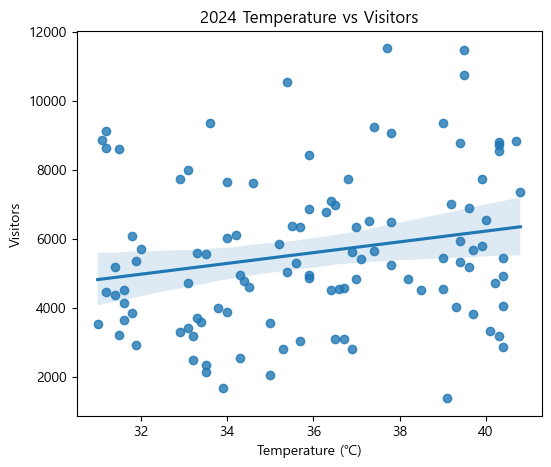

In [26]:
df_2024 = cultural_heat[cultural_heat['year'] == 2024]

plt.figure(figsize=(6,5))
sns.regplot(
    data=df_2024,
    x='max_temp',
    y='art_center_total_visit'
)

plt.title('2024 Temperature vs Visitors')
plt.xlabel('Temperature (℃)')
plt.ylabel('Visitors')
plt.show()


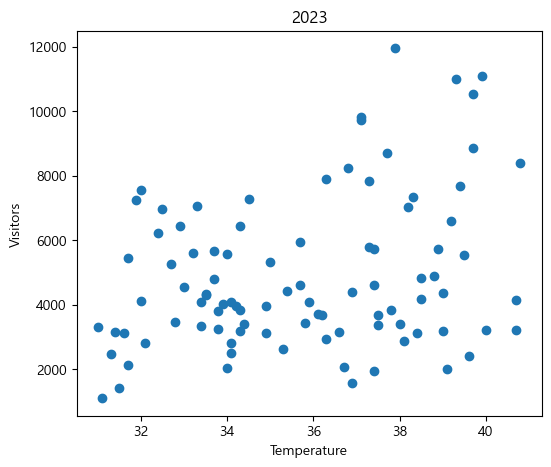

In [27]:
plt.figure(figsize=(6,5))
plt.scatter(df_2023['max_temp'], df_2023['art_center_total_visit'])

plt.xlabel('Temperature')
plt.ylabel('Visitors')
plt.title('2023')

plt.show()


In [28]:
print("2023 상관계수:", df_2023[['max_temp','art_center_total_visit']].corr().iloc[0,1])
print("2024 상관계수:", df_2024[['max_temp','art_center_total_visit']].corr().iloc[0,1])


2023 상관계수: 0.30021453202336745
2024 상관계수: 0.20907318107572945
